# Preprocessing
A notebook in which we investigate whether features created by topic modelling can be useful in predicting the success of a Kickstarter technology project.

## Imports


In [45]:
# Statsmodels for regression
import statsmodels
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col

# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing 
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import PolynomialFeatures #generating interaction terms

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# For reproducability: versions of python, pandas, numpy, scipy, sklearn and statsmodels
import sys
print(sys.version)
print(pd.__version__)
print(np.__version__)
print(scipy.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)
print(sns.__version__)

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Option for numpy
np.set_printoptions(threshold=np.inf)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
1.0.3
1.16.5
1.4.1
0.21.3
0.10.1
0.9.0


## Feature engineering based on topic distributions

In [8]:
# Read in data
topic_distributions = pd.read_csv("C:/Users/Rodger/Documents/Data Science/DS&E/Y2021S1/Strategy & Business Models/SBM/topic_distributions_per_document.csv")
topic_distributions

,General_Description,Ask_Support,Gaming,Energy,Online_Content,Cosmetics,Tech_Education,Riding,Hardware,Music,Drinking,Smartwatches,Sleeping,Cleaning
0,0.0,0.0,0.108664,0.0,0.000000,0.039298,0.061768,0.0,0.342307,0.122283,0.096216,0.229056,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.050659,0.131682,0.169192,0.0,0.170127,0.000000,0.034687,0.441135,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.359952,0.000000,0.0,0.505747,0.000000,0.014969,0.106971,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.552702,0.119173,0.0,0.122303,0.000000,0.191493,0.013961,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.268526,0.032235,0.0,0.512086,0.000000,0.000000,0.066878,0.118504,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0.0,0.0,0.000000,0.0,0.000000,0.924722,0.000000,0.0,0.014240,0.000000,0.000000,0.056391,0.000000,0.0
419,0.0,0.0,0.000000,0.0,0.000000,0.653543,0.299270,0.0,0.000000,0.000000,0.000000,0.030269,0.000000,0.0
420,0.0,0.0,0.000000,0.0,0.000000,0.142407,0.134145,0.0,0.000000,0.513073,0.011870,0.194024,0.000000,0.0
421,0.0,0.0,0.000000,0.0,0.000000,0.744225,0.093744,0.0,0.031727,0.045094,0.072498,0.012202,0.000000,0.0


### H1: Focusing on unique topics leads to commercial project success
For this hypothesis we need to define the concept of 'unique topics'.
We have done so by creating an average project (with average topic distributions),
and then calculating the distance of every project to that average project.
The distance is expressed in Euclidean distance.

In [9]:
# Create the average scores for each topic, add them as a new 'project'
# This is required for the next step.
average_project = topic_distributions.sum()/len(topic_distributions)
topic_distributions_avg = topic_distributions.append(average_project, ignore_index=True)
#topic_distributions_avg

In [10]:
# Using the Euclidean distance we calculate all distances (424x424).
# Then we take the last argument in that ndarray of arrays, which
# corresponds to the previously added 'average project'.
# As the distance from the average project to the average project
# is not relevant (and 0 anyways), we drop the last distance score.
dist_eu = scipy.spatial.distance.cdist(topic_distributions_avg, topic_distributions_avg, 'euclidean')[-1]

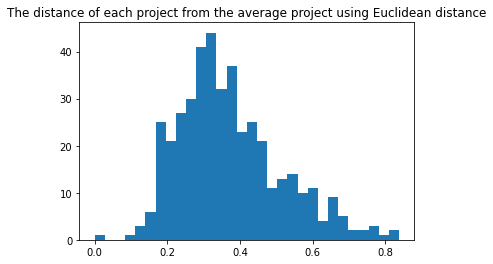

In [11]:
_ = plt.hist(dist_eu, bins=30)
plt.title("The distance of each project from the average project using Euclidean distance")
plt.show()

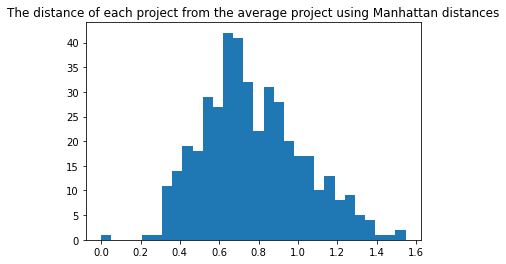

In [12]:
# Using the Manhattan distance we calculate all distances (424x424).
# Then we take the last argument in that ndarray of arrays, which
# corresponds to the previously added 'average project'.
# As the distance from the average project to the average project
# is not relevant (and 0 anyways), we drop the last distance score.
dist_mh = scipy.spatial.distance.cdist(topic_distributions_avg, topic_distributions_avg, 'cityblock')[-1]

_ = plt.hist(dist_mh, bins=30)  
plt.title("The distance of each project from the average project using Manhattan distances")
plt.show()

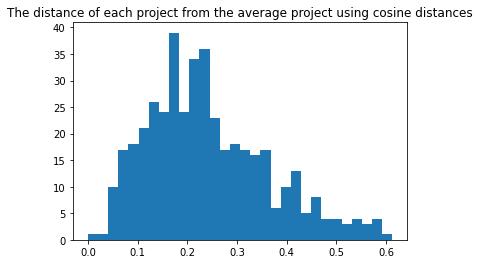

In [13]:
# Using the cosine distance we calculate all distances (424x424).
# Then we take the last argument in that ndarray of arrays, which
# corresponds to the previously added 'average project'.
# As the distance from the average project to the average project
# is not relevant (and 0 anyways), we drop the last distance score.
dist_co = scipy.spatial.distance.cdist(topic_distributions_avg, topic_distributions_avg, 'cosine')[-1]

_ = plt.hist(dist_co, bins=30) 
plt.title("The distance of each project from the average project using cosine distances")
plt.show()

### H2: Focusing on fewer topics increases the chance of project success.

Analytically, we define "the number of topics a project focusses on" as the sum per project of each topic that has a topic proportion above 0.10.

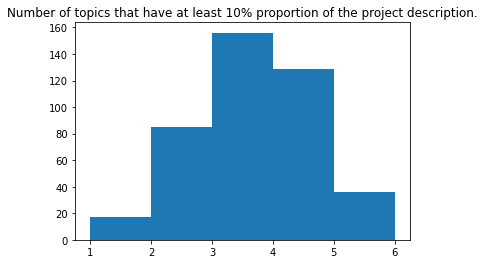

In [17]:
number_of_topics = topic_distributions[topic_distributions >= 0.1].count(axis=1)

_ = plt.hist(number_of_topics, bins=5)
plt.title("Number of topics that have at least 10% proportion of the project description.")
plt.show()

### Checking whether a logtransform for number of topics is feasible

Because the rho with topic uniqueness is 0.61.

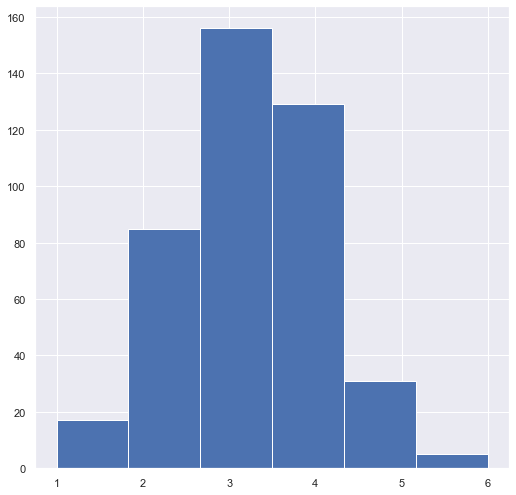

In [82]:
df['number_of_topics'].hist(bins=6)

In [131]:
from scipy.stats import shapiro

scipy.stats.shapiro(df['number_of_topics'])


(0.9159783720970154, 1.3377503891144702e-14)

In [132]:
## i don't get above results, it shows a very low p value (thus very confidently rejecting the null hypothesis of normality)



In [127]:
df

,creator_slug,project_slug,Goal_USD,Pledge_USD,Number_Backers,Project_nb_updates,succesful,sparse_terms,duration,update_freq,description_length,number_of_topics,topic_uniqueness_eu,topic_uniqueness_mh,topic_uniqueness_co
0,1655200223,the-worlds-most-advanced-stain-and-odour-repel...,16736.25,128125.83,1529.0,2.0,True,57,43,0.046512,507,4,0.303051,0.778233,0.232398
1,slingboard,worlds-first-2-in-1-paddleboard-skateboard-hybrid,10000.00,2205.00,15.0,0.0,False,10,41,0.000000,106,4,0.332028,0.663279,0.226646
2,70979829,ar-interactive-marketing-products,17000.00,62.00,5.0,0.0,False,10,60,0.000000,162,3,0.386505,0.835000,0.200218
3,1394449697,bolt-drones-introducing-a-whole-new-flight-exp...,100000.00,218522.77,1055.0,10.0,True,51,46,0.217391,843,4,0.369642,0.703436,0.197875
4,1760623143,complete-guide-to-self-promotion-for-techies-a...,512.28,1169.28,17.0,2.0,True,34,16,0.125000,550,3,0.389377,0.878677,0.242698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,541327450,inform8r-the-clean-messaging-app,30000.00,552.00,5.0,4.0,False,108,30,0.133333,1333,1,0.763277,1.382071,0.420166
419,finncast,live-video-broadcast-software-with-a-virtual-c...,28106.09,221.48,5.0,0.0,False,10,30,0.000000,125,2,0.533728,1.123017,0.323939
420,floraforplants,flora-your-intelligent-plant-watering-ally,103458.01,2249.47,51.0,0.0,False,34,30,0.000000,398,4,0.557147,1.030582,0.577261
421,457723537,prime-hunting-server-farm,9196.72,2.63,2.0,0.0,False,52,28,0.000000,497,1,0.574125,1.042748,0.342744


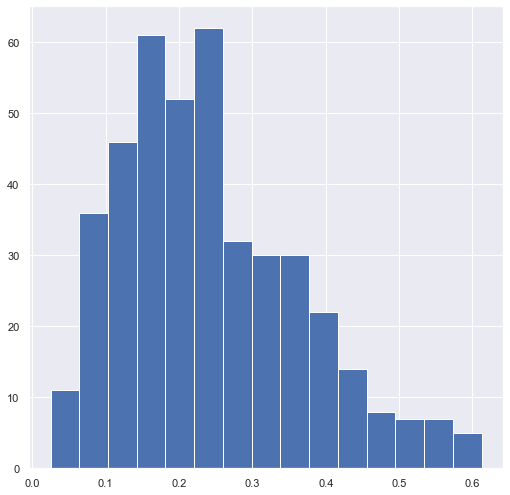

In [85]:
df['topic_uniqueness_co'].hist(bins=15)

#### No, it is normally distributed.

## Kickstarter data

In [18]:
data = pd.read_csv("C:/Users/Rodger/Documents/Data Science/DS&E/Y2021S1/Strategy & Business Models/SBM/final_data.csv")
#data

In [19]:
df = data.copy()

# We count the number of words of the (cleaned) description,
# by creating a string instance of the pandas series, splitting
# by spaces (which we know works due to the preprocessing), then
# creating a string instance again (allows for series operators)
# and ask the length of each element.
df['description_length'] = df['clean'].str.split(" ").str.len()

# create y
# (yes, it's a spelling error, as it should be successful
# and yes, there's some irony involved here)
y_success = df['succesful']

# Drop irrelevant data for the regression (for convenience)
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Blurb', 'my_id', 'Category', 'Location', 'Staff_recommended', 
                 'Created_at', 'Launched_at', 'Deadline', 'Disable_Communication', 'Project_nb_FAQ', 
                 'Project_Community_top_cities', 'Project_Community_top_countries', 'Project_Community_nb_new_backers', 
                 'Project_Community_nb_returning_backers', 'Creator_description', 'Creator_nb_projects', 
                 'Creator_date_joined', 'Creator_nb_backed', 'Creator_location', 'Creator_made_comments', 
                 'Project_nb_comments', 'Project_description', 'number_backers_log', 'categorical', 'remainder', 
                 'percentage_log', 'percentage', 'flops', 'rockstars', 'clean',
                ], axis=1, inplace=True)
df

,creator_slug,project_slug,Goal_USD,Pledge_USD,Number_Backers,Project_nb_updates,succesful,sparse_terms,duration,update_freq,description_length
0,1655200223,the-worlds-most-advanced-stain-and-odour-repel...,16736.25,128125.83,1529.0,2.0,True,57,43,0.046512,507
1,slingboard,worlds-first-2-in-1-paddleboard-skateboard-hybrid,10000.00,2205.00,15.0,0.0,False,10,41,0.000000,106
2,70979829,ar-interactive-marketing-products,17000.00,62.00,5.0,0.0,False,10,60,0.000000,162
3,1394449697,bolt-drones-introducing-a-whole-new-flight-exp...,100000.00,218522.77,1055.0,10.0,True,51,46,0.217391,843
4,1760623143,complete-guide-to-self-promotion-for-techies-a...,512.28,1169.28,17.0,2.0,True,34,16,0.125000,550
...,...,...,...,...,...,...,...,...,...,...,...
418,541327450,inform8r-the-clean-messaging-app,30000.00,552.00,5.0,4.0,False,108,30,0.133333,1333
419,finncast,live-video-broadcast-software-with-a-virtual-c...,28106.09,221.48,5.0,0.0,False,10,30,0.000000,125
420,floraforplants,flora-your-intelligent-plant-watering-ally,103458.01,2249.47,51.0,0.0,False,34,30,0.000000,398
421,457723537,prime-hunting-server-farm,9196.72,2.63,2.0,0.0,False,52,28,0.000000,497


In [20]:
# Adding the two newly created predictors
df['number_of_topics'] = number_of_topics
df['topic_uniqueness_eu'] = dist_eu[0:423]
df['topic_uniqueness_mh'] = dist_mh[0:423]
df['topic_uniqueness_co'] = dist_co[0:423]

## Helper functions

These functions will be called everytime a new model is fit.

In [122]:
X = df[['succesful', 'number_of_topics', 'topic_uniqueness_eu', 'topic_uniqueness_mh', 'topic_uniqueness_co']]

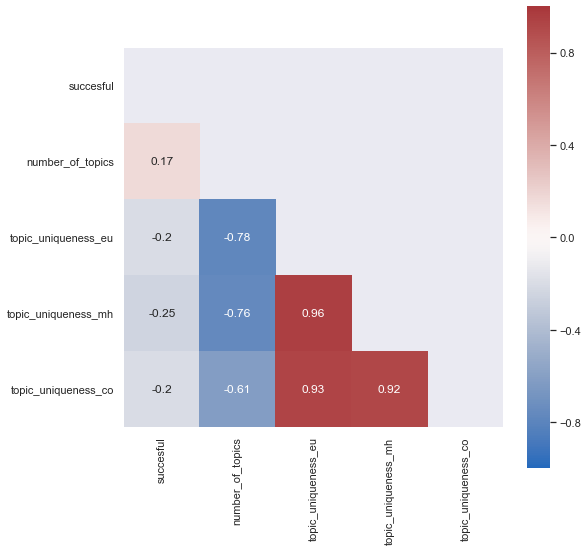

In [123]:
# Steps to remove redundant values

mask = np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True

# How to remove redundant correlation
# <https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib>
# Correlation matrix
sns.set(rc={'figure.figsize': (8.5,8.5)})
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, square=True, cmap='vlag', annot=True, mask=mask);


In [29]:
def model_diagnostics(model, X, y):
    '''
    This is a post-regression function which is called by the fit_probit function.
    It contains plots of partial regressions, a prediction table,
    a table of VIFs and a correlation matrix.
    As everything is displayed during runtime, it does not return anything.
    '''
    
    # Steps to remove redundant values
    full_correlation_table = X.copy()
    full_correlation_table['success'] = y.copy()
    mask = np.zeros_like(full_correlation_table.corr())
    mask[np.triu_indices_from(mask)] = True

    # How to remove redundant correlation
    # <https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib>
    # Correlation matrix
    sns.set(rc={'figure.figsize': (8.5,8.5)})
    sns.heatmap(full_correlation_table.corr().round(2), vmin=-1, vmax=1, square=True, cmap='vlag', annot=True, mask=mask);
    
    # Prediction table
    display(model.pred_table())
    
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    # Source: https://etav.github.io/python/vif_factor_python.html
    display(vif)
    
    # Partial regressions
    fig = sm.graphics.plot_partregress_grid(model)
    fig.tight_layout(pad=1.5)
    
    

In [30]:
def fit_probit(X, y): 
    '''
    This function fits the probit model based on the feature set X after adding an intercept.
    After fitting, it displays the summary, calls the function model_diagnostics for 
    additional output, and returns the model object.  
    '''
    # Add an intercept
    X_n = statsmodels.tools.tools.add_constant(X, prepend=False, has_constant='skip')
    
    # Fitting the model
    log_reg = sm.Probit(y, X_n).fit() 
    
    display(log_reg.summary())
    model_diagnostics(log_reg, X, y)
    
    # Returning the trained model
    return log_reg

# Regression analyses
Comparing features in a vacuum, compared to the baseline of section 2.1.

## Can we create a baseline model consistent with the literature?

Based on our literature review, we take the following features as baseline:
* Project funding goal
* Project duration
* Length of description
* Number of project updates
* Number of backers
* Amount of sparse terms (as proxy for spelling errors)


We first check whether these results are consistent with our data.

In [31]:
literature_predictors = ['Goal_USD', 'duration', 'description_length', 'Project_nb_updates', 'Number_Backers', 'sparse_terms']

Optimization terminated successfully.
         Current function value: 0.209195
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      416
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6565
Time:                        14:08:13   Log-Likelihood:                -88.490
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 5.064e-70
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Goal_USD           -3.428e-05   5.78e-06     -5.932      0.000   -4.56e-05    -2.3e-05
duration              -0.0183      0.008     -2.337      0.019      -0.034      -0.003
description_length     0.0011      0.001      1.488      0.137      -0.000       0.003
Project_nb_updates     0.1358      0.035      3.895      0.000       0.067       0.204
Number_Backers         0.0270      0.005      5.910      0.000       0.018       0.036
sparse_terms          -0.0129      0.008     -1.700      0.089      -0.028       0.002
const                  0.1480      0.359      0.412      0.680      -0.556       0.852
======================================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[111.,  15.],
       [ 25., 272.]])

,VIF Factor,features
0,1.331108,Goal_USD
1,2.576520,duration
2,9.997447,description_length
3,2.134011,Project_nb_updates
4,1.343576,Number_Backers
5,7.460043,sparse_terms


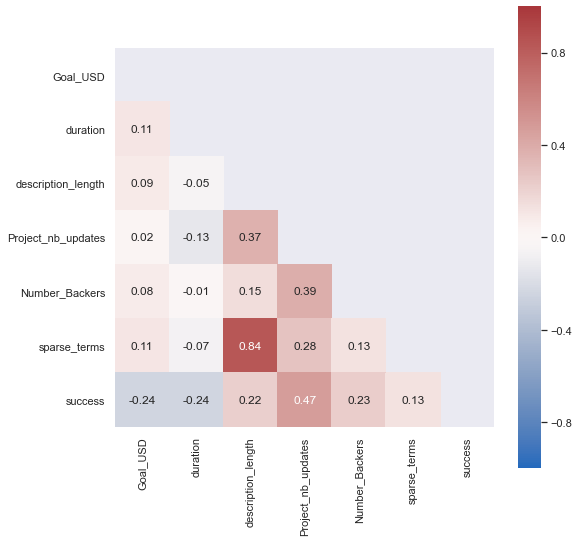

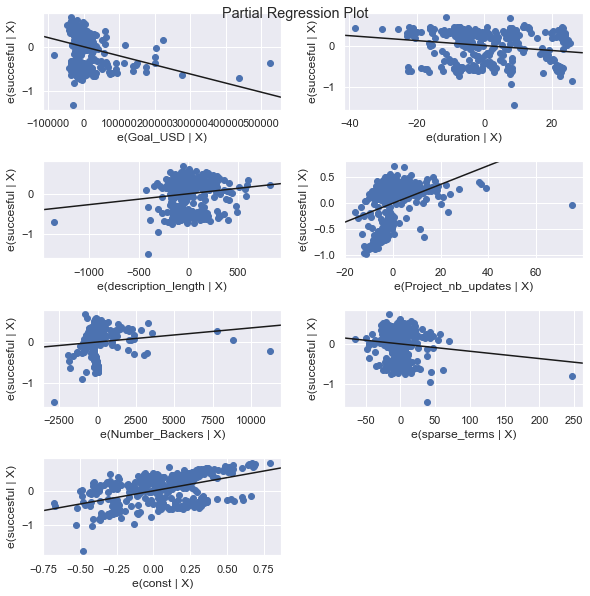

In [41]:
X_literature = df[literature_predictors]
model_literature = fit_probit(X_literature, y_success)

We see that in the model _description length_ (0.137) and _sparse terms_ (0.089) are not statistically significant; the remaining predictors are. The model performs quite well, with 111 TN and 272 TP. 

Furthermore, we see that both _description length_ (10.00) and _sparse terms_ (7.46) have a VIF of over 5, so they should be treated with caution. In the correlation matrix, we also see that these two rascals have a correlation of 0.84. All of this indicates that they largely contain the same info and one should be dropped. As _description length_ has the lower p-value and the higher VIF-value, we elect for _sparse terms_. 

Optimization terminated successfully.
         Current function value: 0.212029
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      417
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6519
Time:                        14:08:16   Log-Likelihood:                -89.688
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 1.917e-70
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Goal_USD            -3.35e-05    5.7e-06     -5.881      0.000   -4.47e-05   -2.23e-05
duration              -0.0176      0.008     -2.276      0.023      -0.033      -0.002
Project_nb_updates     0.1378      0.033      4.136      0.000       0.073       0.203
Number_Backers         0.0266      0.004      5.939      0.000       0.018       0.035
sparse_terms          -0.0041      0.004     -1.128      0.259      -0.011       0.003
const                  0.2490      0.348      0.715      0.474      -0.433       0.931
======================================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[111.,  15.],
       [ 24., 273.]])

,VIF Factor,features
0,1.331096,Goal_USD
1,2.200062,duration
2,1.966674,Project_nb_updates
3,1.342056,Number_Backers
4,2.256497,sparse_terms


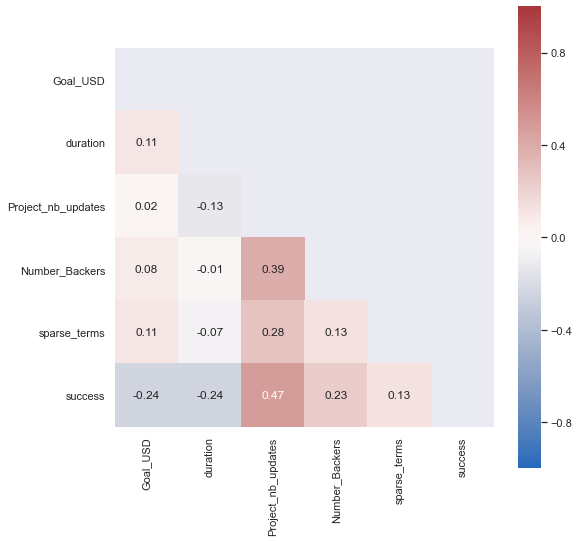

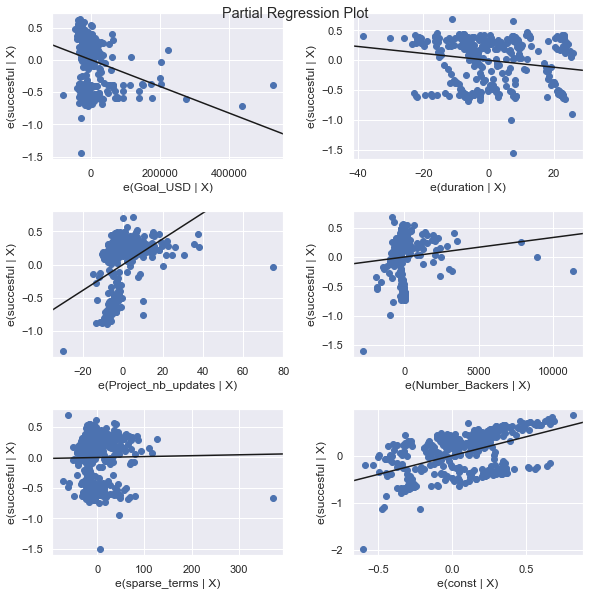

In [42]:
no_description_length = ['Goal_USD', 'duration', 'Project_nb_updates', 'Number_Backers', 'sparse_terms']
X_no_descr = df[no_description_length]
model_no_description = fit_probit(X_no_descr, y_success)

### Yes, largely.

Though _description length_ and _sparse terms_ are not statistically significant, we only have to drop one of them to combat multicollinearity. The remaining predictor set, dubbed _baseline_predictors_ provides a decently performing model, in line with the literature. We will take those predictors as standard.

In [48]:
%%capture
# This is the same model as above
# But for naming convenience later on I run it again (without output)
baseline_predictors = ['Goal_USD', 'duration', 'Project_nb_updates', 'Number_Backers', 'sparse_terms']
X_baseline = df[baseline_predictors]
model_baseline = fit_probit(X_baseline, y_success)

## Hypothesis testing

### Does adding both _topic uniqueness_ and _number of topics_ result in a better model?

Optimization terminated successfully.
         Current function value: 0.197654
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      415
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6755
Time:                        14:19:21   Log-Likelihood:                -83.608
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 3.235e-71
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Goal_USD            -3.505e-05   6.02e-06     -5.822      0.000   -4.69e-05   -2.33e-05
duration               -0.0205      0.008     -2.535      0.011      -0.036      -0.005
Project_nb_updates      0.1505      0.035      4.268      0.000       0.081       0.220
Number_Backers          0.0274      0.005      5.802      0.000       0.018       0.037
sparse_terms           -0.0030      0.003     -0.908      0.364      -0.009       0.003
topic_uniqueness_co    -3.8040      1.165     -3.266      0.001      -6.087      -1.521
number_of_topics       -0.1759      0.140     -1.257      0.209      -0.450       0.098
const                   1.8183      0.755      2.407      0.016       0.338       3.299
=======================================================================================

Possibly complete quasi-separation: A fraction 0.42 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[114.,  12.],
       [ 17., 280.]])

,VIF Factor,features
0,1.332622,Goal_USD
1,7.960422,duration
2,2.099257,Project_nb_updates
3,1.364083,Number_Backers
4,2.413580,sparse_terms
5,3.812267,topic_uniqueness_co
6,6.340435,number_of_topics


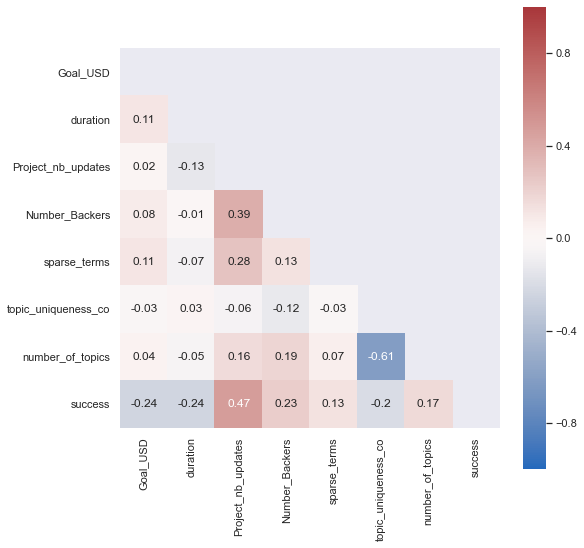

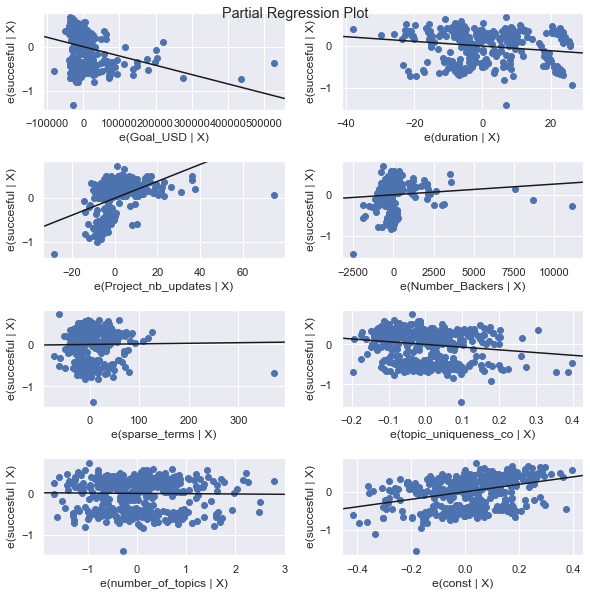

In [49]:
X_hypotheses = df[baseline_predictors + ['topic_uniqueness_co', 'number_of_topics']]
model_hypotheses = fit_probit(X_hypotheses, y_success)

### No.

We see that _topic uniqueness_ remains statistically significant, though the coefficient is even more negative. _Number of topics_  ohwever is not statistically significant (p = 0.209). Additionally, both _duration_ and _number of topics_ have a VIF of over 5. All in all this suggests that the model with both _topic uniqueness_ and _number of topics_ does not significantly improve the model with just _topic uniqueness_. 

In [50]:
predictor_set = baseline_predictors + ['topic_uniqueness_co', 'number_of_topics']
predictor_set

['Goal_USD',
 'duration',
 'Project_nb_updates',
 'Number_Backers',
 'sparse_terms',
 'topic_uniqueness_co',
 'number_of_topics']

# Interaction effects

We pose that number of updates and duration may be a moderator. We will first create all interaction terms, then extract those (this was the more convenient method given the already present code of previous iterations)

In [57]:
x_interaction.shape

(423, 28)

In [58]:
x_interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(df[predictor_set])

interaction_df = pd.DataFrame(x_interaction, columns = ['Goal_USD', 'duration', 'Project_nb_updates', 
    'Number_Backers', 'sparse_terms', 'topic_uniqueness_co', 'number_of_topics',
                                                        
        'Goal_USD:duration', 
        'Goal_USD:Project_nb_updates', 
        'Goal_USD:Number_Backers', 
        'Goal_USD:sparse_terms', 
        'Goal_USD:topic_uniqueness_co',
        'Goal_USD:number_of_topics',
                                                        

        'duration:Project_nb_updates', 
        'duration:Number_Backers', 
        'duration:sparse_terms', 
        'duration:topic_uniqueness_co', 
        'duration:number_of_topics', 

        'Project_nb_updates:Number_Backers', 
        'Project_nb_updates:sparse_terms', 
        'Project_nb_updates:topic_uniqueness_co',
        'Project_nb_updates:number_of_topics',

        'Number_Backers:sparse_terms',
        'Number_Backers:topic_uniqueness_co',
        'Number_Backers:number_of_topics',

        'sparse_terms:topic_uniqueness_co',
        'sparse_terms:number_of_topics',
                                                        
        'topic_uniqueness_co:number_of_topics'
       ])

## Does _duration_ have an interaction effect?

Optimization terminated successfully.
         Current function value: 0.194807
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      414
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6801
Time:                        14:34:49   Log-Likelihood:                -82.403
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 7.257e-71
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Goal_USD                     -3.582e-05   6.09e-06     -5.877      0.000   -4.78e-05   -2.39e-05
duration                         0.0088      0.021      0.427      0.669      -0.032       0.049
Project_nb_updates               0.1533      0.036      4.265      0.000       0.083       0.224
Number_Backers                   0.0280      0.005      5.815      0.000       0.019       0.037
sparse_terms                    -0.0028      0.003     -0.868      0.385      -0.009       0.004
topic_uniqueness_co              0.5465      3.084      0.177      0.859      -5.498       6.590
number_of_topics                -0.1925      0.142     -1.360      0.174      -0.470       0.085
duration:topic_uniqueness_co    -0.1313      0.087     -1.514      0.130      -0.301       0.039
const                            0.8764      0.968      0.906      0.365      -1.020       2.773
================================================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[114.,  12.],
       [ 14., 283.]])

,VIF Factor,features
0,1.340649,Goal_USD
1,24.056010,duration
2,2.104017,Project_nb_updates
3,1.364175,Number_Backers
4,2.422076,sparse_terms
5,18.742676,topic_uniqueness_co
6,11.630584,number_of_topics
7,32.852545,duration:topic_uniqueness_co


Optimization terminated successfully.
         Current function value: 0.197166
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      414
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6763
Time:                        14:34:50   Log-Likelihood:                -83.401
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 1.936e-70
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Goal_USD                  -3.547e-05   6.09e-06     -5.820      0.000   -4.74e-05   -2.35e-05
duration                     -0.0027      0.029     -0.093      0.926      -0.059       0.054
Project_nb_updates            0.1536      0.036      4.281      0.000       0.083       0.224
Number_Backers                0.0277      0.005      5.803      0.000       0.018       0.037
sparse_terms                 -0.0030      0.003     -0.890      0.373      -0.009       0.004
topic_uniqueness_co          -3.7906      1.166     -3.252      0.001      -6.075      -1.506
number_of_topics              0.0358      0.358      0.100      0.920      -0.666       0.737
duration:number_of_topics    -0.0058      0.009     -0.643      0.520      -0.024       0.012
const                         1.1558      1.273      0.908      0.364      -1.340       3.652
=============================================================================================

Possibly complete quasi-separation: A fraction 0.42 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[114.,  12.],
       [ 17., 280.]])

,VIF Factor,features
0,1.342026,Goal_USD
1,29.553182,duration
2,2.100815,Project_nb_updates
3,1.374340,Number_Backers
4,2.440327,sparse_terms
5,6.259682,topic_uniqueness_co
6,16.828201,number_of_topics
7,40.567906,duration:number_of_topics


Optimization terminated successfully.
         Current function value: 0.190320
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      413
Method:                           MLE   Df Model:                            9
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6875
Time:                        14:34:53   Log-Likelihood:                -80.505
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 7.732e-71
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Goal_USD                     -3.815e-05    6.4e-06     -5.960      0.000   -5.07e-05   -2.56e-05
duration                         0.1061      0.055      1.941      0.052      -0.001       0.213
Project_nb_updates               0.1684      0.038      4.389      0.000       0.093       0.244
Number_Backers                   0.0294      0.005      5.859      0.000       0.020       0.039
sparse_terms                    -0.0026      0.003     -0.761      0.447      -0.009       0.004
topic_uniqueness_co              4.5363      3.699      1.226      0.220      -2.713      11.786
number_of_topics                 0.6138      0.442      1.388      0.165      -0.253       1.481
duration:topic_uniqueness_co    -0.2515      0.107     -2.350      0.019      -0.461      -0.042
duration:number_of_topics       -0.0228      0.012     -1.923      0.054      -0.046       0.000
const                           -2.5683      2.025     -1.268      0.205      -6.537       1.401
================================================================================================

Possibly complete quasi-separation: A fraction 0.44 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[112.,  14.],
       [ 16., 281.]])

,VIF Factor,features
0,1.356161,Goal_USD
1,37.984153,duration
2,2.104514,Project_nb_updates
3,1.374639,Number_Backers
4,2.442970,sparse_terms
5,25.821304,topic_uniqueness_co
6,27.416422,number_of_topics
7,35.234432,duration:topic_uniqueness_co
8,43.509175,duration:number_of_topics


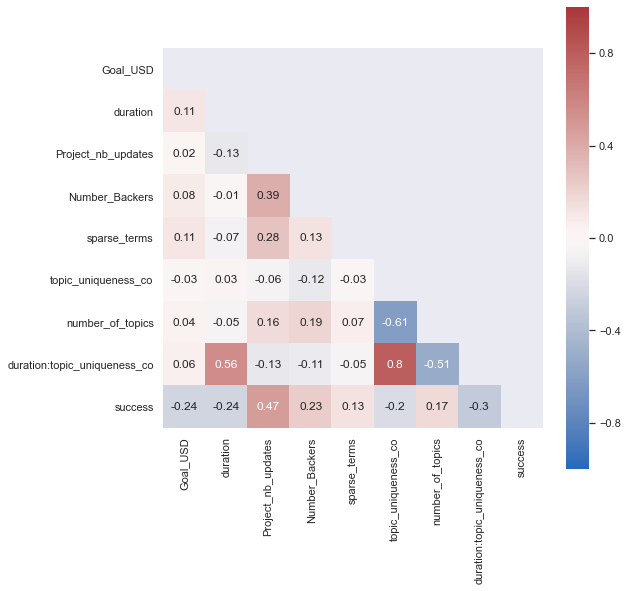

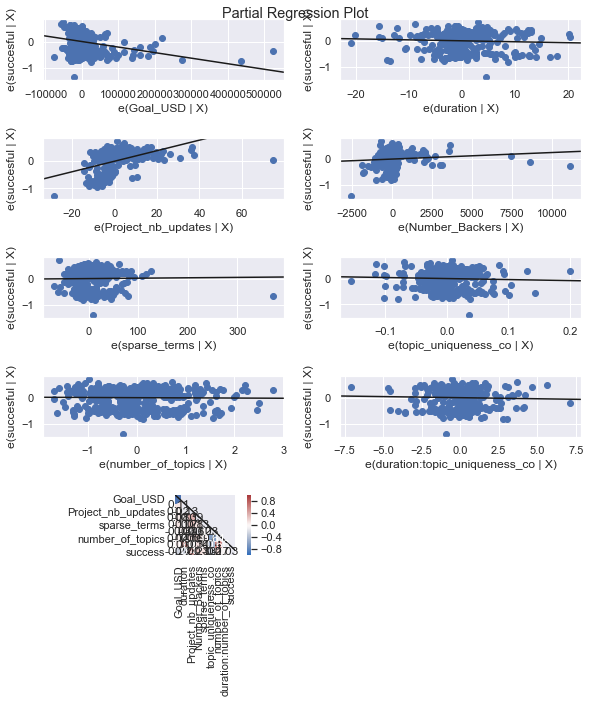

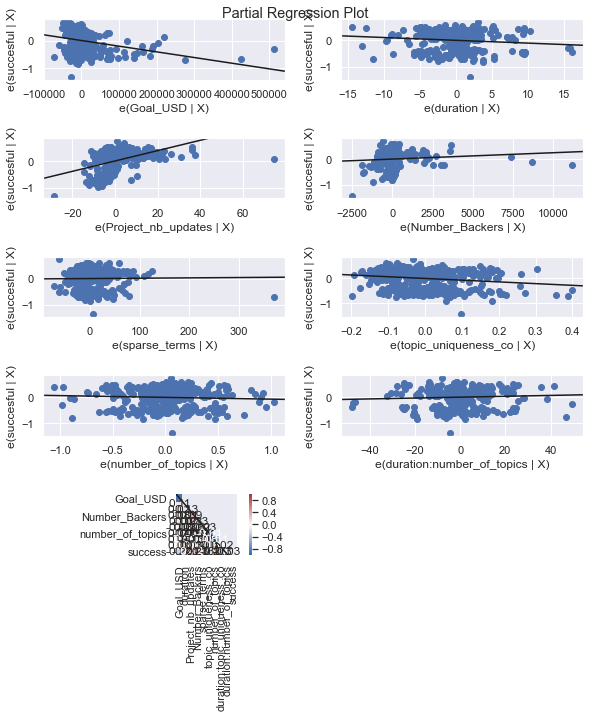

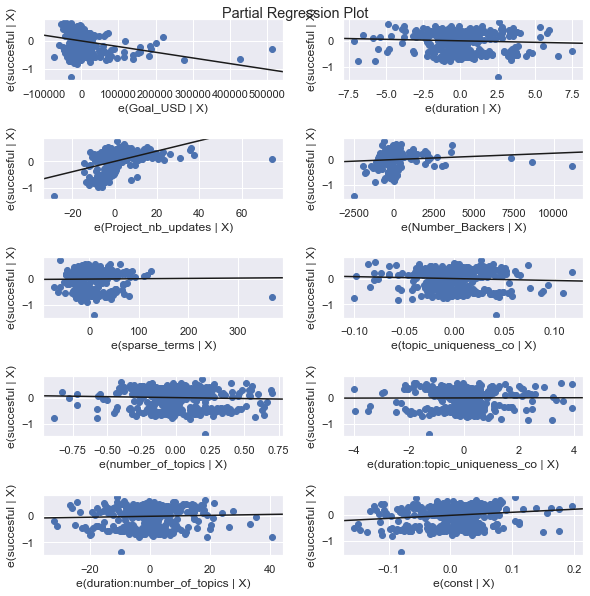

In [59]:
df_mod_duration_tu = interaction_df[predictor_set + ['duration:topic_uniqueness_co'
            ]]
df_mod_duration_not = interaction_df[predictor_set + ['duration:number_of_topics'
            ]]
df_mod_duration_both = interaction_df[predictor_set + ['duration:topic_uniqueness_co', 'duration:number_of_topics'
            ]]

model_mod_duration_tu = fit_probit(df_mod_duration_tu, y_success)
model_mod_duration_not = fit_probit(df_mod_duration_not, y_success)
model_mod_duration_both = fit_probit(df_mod_duration_both, y_success)

In [73]:
dfoutput = summary_col([
    model_mod_duration_tu, # duration with topic uniqueness
    model_mod_duration_not, # duration with number of topics
    model_mod_duration_both, # duration with both



],stars=True, model_names=['with topic_uniqueness_co', 'with #topics', 'duration with both'],
regressor_order=['Goal_USD', 'Number_Backers', 'Project_nb_updates', 'sparse_terms', 'number_of_topics', 
                 'topic_uniqueness_co', 'duration', 'duration:topic_uniqueness_co', 'duration:number_of_topics'])
print(dfoutput)


                             with topic_uniqueness_co with #topics duration with both
-------------------------------------------------------------------------------------
Goal_USD                     -0.0000***               -0.0000***   -0.0000***        
                             (0.0000)                 (0.0000)     (0.0000)          
Number_Backers               0.0280***                0.0277***    0.0294***         
                             (0.0048)                 (0.0048)     (0.0050)          
Project_nb_updates           0.1533***                0.1536***    0.1684***         
                             (0.0359)                 (0.0359)     (0.0384)          
sparse_terms                 -0.0028                  -0.0030      -0.0026           
                             (0.0032)                 (0.0033)     (0.0034)          
number_of_topics             -0.1925                  0.0358       0.6138            
                             (0.1416)                

### Possibly.

Though the interaction variable is statistically significant (p = 0.003), duration is not (p = 0.550). Their VIFs are ~25 and the correlation between _duration:number of updates_ and _number of updates_ is 0.96. 

## Does _number of updates_ have an interaction effect?

In [117]:
df['Goal_USD'].mean()

28608.651938534276

Optimization terminated successfully.
         Current function value: 0.189680
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      414
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6886
Time:                        14:44:48   Log-Likelihood:                -80.235
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 8.609e-72
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Goal_USD                                -3.83e-05   6.34e-06     -6.037      0.000   -5.07e-05   -2.59e-05
duration                                  -0.0217      0.008     -2.606      0.009      -0.038      -0.005
Project_nb_updates                         0.3612      0.095      3.817      0.000       0.176       0.547
Number_Backers                             0.0260      0.005      5.432      0.000       0.017       0.035
sparse_terms                              -0.0030      0.003     -0.915      0.360      -0.009       0.003
topic_uniqueness_co                       -2.5501      1.265     -2.017      0.044      -5.028      -0.072
number_of_topics                          -0.2681      0.149     -1.797      0.072      -0.561       0.024
Project_nb_updates:topic_uniqueness_co    -0.5994      0.234     -2.564      0.010      -1.058      -0.141
const                                      1.8180      0.779      2.334      0.020       0.292       3.344
==========================================================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[114.,  12.],
       [ 16., 281.]])

,VIF Factor,features
0,1.342220,Goal_USD
1,7.999437,duration
2,10.836526,Project_nb_updates
3,1.397866,Number_Backers
4,2.463172,sparse_terms
5,5.827897,topic_uniqueness_co
6,7.716402,number_of_topics
7,8.705149,Project_nb_updates:topic_uniqueness_co


Optimization terminated successfully.
         Current function value: 0.197382
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      414
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.6759
Time:                        14:44:50   Log-Likelihood:                -83.493
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 2.117e-70
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Goal_USD                            -3.542e-05   6.08e-06     -5.826      0.000   -4.73e-05   -2.35e-05
duration                               -0.0210      0.008     -2.574      0.010      -0.037      -0.005
Project_nb_updates                      0.1107      0.088      1.255      0.209      -0.062       0.284
Number_Backers                          0.0273      0.005      5.777      0.000       0.018       0.037
sparse_terms                           -0.0030      0.003     -0.919      0.358      -0.009       0.003
topic_uniqueness_co                    -3.7609      1.167     -3.222      0.001      -6.049      -1.473
number_of_topics                       -0.2156      0.163     -1.324      0.186      -0.535       0.104
Project_nb_updates:number_of_topics     0.0130      0.027      0.485      0.628      -0.040       0.066
const                                   1.9487      0.803      2.426      0.015       0.374       3.523
=======================================================================================================

Possibly complete quasi-separation: A fraction 0.42 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[114.,  12.],
       [ 17., 280.]])

,VIF Factor,features
0,1.347895,Goal_USD
1,8.097057,duration
2,18.018234,Project_nb_updates
3,1.419795,Number_Backers
4,2.414764,sparse_terms
5,4.864699,topic_uniqueness_co
6,8.330703,number_of_topics
7,20.271325,Project_nb_updates:number_of_topics


Optimization terminated successfully.
         Current function value: 0.181499
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              succesful   No. Observations:                  423
Model:                         Probit   Df Residuals:                      413
Method:                           MLE   Df Model:                            9
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                  0.7020
Time:                        14:44:52   Log-Likelihood:                -76.774
converged:                       True   LL-Null:                       -257.63
Covariance Type:            nonrobust   LLR p-value:                 1.993e-72
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Goal_USD                               -4.079e-05   6.75e-06     -6.042      0.000    -5.4e-05   -2.76e-05
duration                                  -0.0196      0.009     -2.280      0.023      -0.037      -0.003
Project_nb_updates                         1.0489      0.291      3.607      0.000       0.479       1.619
Number_Backers                             0.0252      0.005      5.112      0.000       0.016       0.035
sparse_terms                              -0.0031      0.004     -0.869      0.385      -0.010       0.004
topic_uniqueness_co                       -1.3381      1.359     -0.984      0.325      -4.002       1.326
number_of_topics                          -0.0641      0.169     -0.380      0.704      -0.395       0.266
Project_nb_updates:topic_uniqueness_co    -1.4940      0.427     -3.502      0.000      -2.330      -0.658
Project_nb_updates:number_of_topics       -0.1162      0.044     -2.634      0.008      -0.203      -0.030
const                                      0.7886      0.883      0.893      0.372      -0.943       2.520
==========================================================================================================

Possibly complete quasi-separation: A fraction 0.47 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

array([[113.,  13.],
       [ 19., 278.]])

,VIF Factor,features
0,1.349501,Goal_USD
1,8.301642,duration
2,52.160336,Project_nb_updates
3,1.425076,Number_Backers
4,2.471928,sparse_terms
5,5.946369,topic_uniqueness_co
6,8.602346,number_of_topics
7,11.842950,Project_nb_updates:topic_uniqueness_co
8,27.578193,Project_nb_updates:number_of_topics


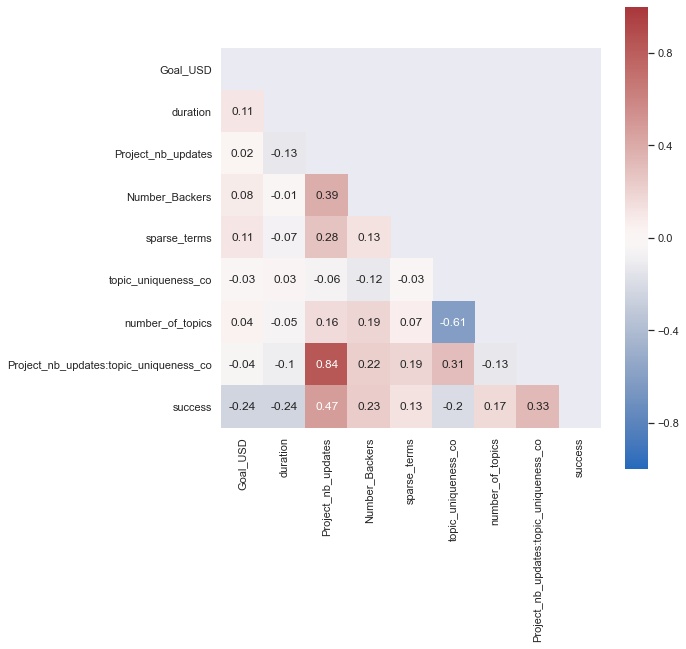

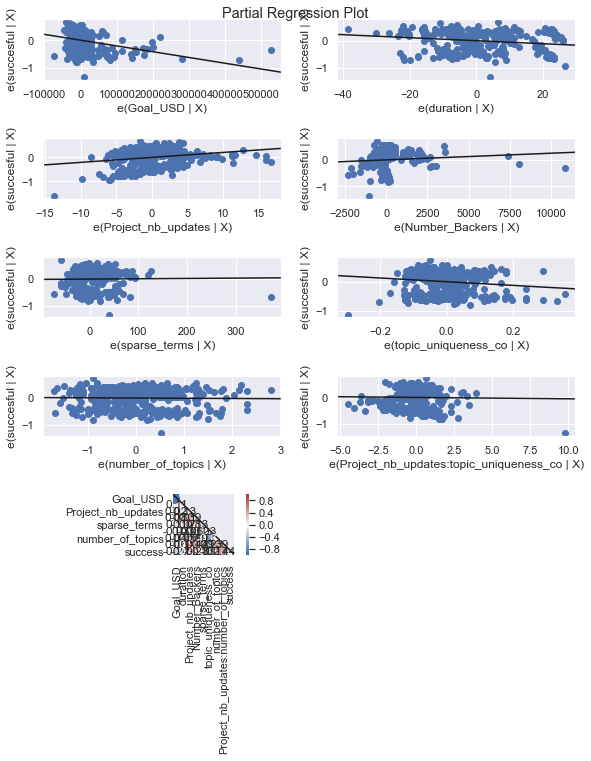

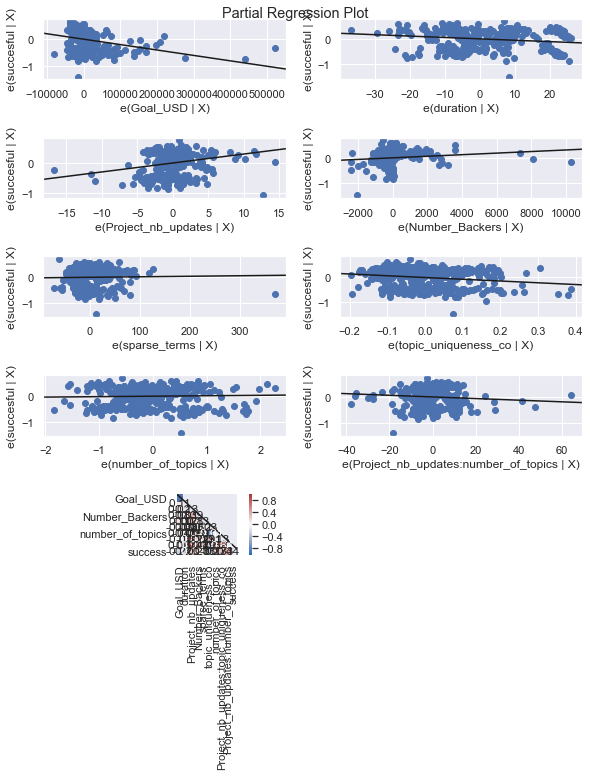

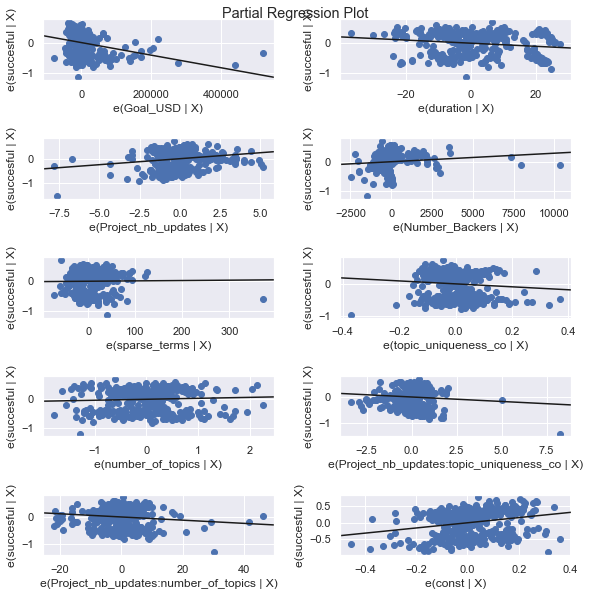

In [74]:
df_mod_updates_tu = interaction_df[predictor_set + ['Project_nb_updates:topic_uniqueness_co'
            ]]
df_mod_updates_not = interaction_df[predictor_set + ['Project_nb_updates:number_of_topics'
            ]]
df_mod_updates_both = interaction_df[predictor_set + ['Project_nb_updates:topic_uniqueness_co', 'Project_nb_updates:number_of_topics'
            ]]

model_mod_updates_tu = fit_probit(df_mod_updates_tu, y_success)
model_mod_updates_not = fit_probit(df_mod_updates_not, y_success)
model_mod_updates_both = fit_probit(df_mod_updates_both, y_success)

In [75]:
dfoutput = summary_col([
    model_mod_updates_tu, # duration with topic uniqueness
    model_mod_updates_not, # duration with number of topics
    model_mod_updates_both, # duration with both



],stars=True, model_names=['with topic_uniqueness_co', 'with #topics', '#updates with both'],
regressor_order=['Goal_USD', 'Number_Backers', 'Project_nb_updates', 'sparse_terms', 'number_of_topics', 
                 'topic_uniqueness_co', 'duration', 'Project_nb_updates:topic_uniqueness_co', 'Project_nb_updates:number_of_topics'])
print(dfoutput)


                                       with topic_uniqueness_co with #topics #updates with both
-----------------------------------------------------------------------------------------------
Goal_USD                               -0.0000***               -0.0000***   -0.0000***        
                                       (0.0000)                 (0.0000)     (0.0000)          
Number_Backers                         0.0260***                0.0273***    0.0252***         
                                       (0.0048)                 (0.0047)     (0.0049)          
Project_nb_updates                     0.3612***                0.1107       1.0489***         
                                       (0.0946)                 (0.0882)     (0.2908)          
sparse_terms                           -0.0030                  -0.0030      -0.0031           
                                       (0.0033)                 (0.0032)     (0.0035)          
number_of_topics                       

# Overview

The models compared below are:

1. y ~ baseline + z
2. y ~ baseline + x1 + x2 + z
3. y ~ baseline + x1 + x2 + x1*z + z
4. y ~ baseline + x1 + x2 + x2*z + z
5. y ~ baseline + x1 + x2 + x1*z + x2*z + z



## Number of updates as moderator

In [153]:
dfoutput = summary_col([
    model_baseline, # model 1
    model_hypotheses, # model 2
    model_mod_updates_tu, # duration with topic uniqueness
    model_mod_updates_not, # duration with number of topics
    model_mod_updates_both,



],stars=True, model_names=['baseline', '| new predictors', '| moder. topic uniq.', '| moder. #updates', '| moder. both'],
regressor_order=['Goal_USD', 'duration', 'Number_Backers', 'Project_nb_updates', 'sparse_terms', 'number_of_topics', 
                 'topic_uniqueness_co', 'Project_nb_updates:number_of_topics', 'Project_nb_updates:topic_uniqueness_co',],
info_dict = {"Observations":lambda x:(x.nobs), "Log-likelihood": lambda x:(x.llf), "Pseudo-r2": lambda x:x.prsquared})

print(dfoutput)


                                        baseline  | new predictors | moder. topic uniq. | moder. #updates | moder. both
-----------------------------------------------------------------------------------------------------------------------
Goal_USD                               -0.0000*** -0.0000***       -0.0000***           -0.0000***        -0.0000***   
                                       (0.0000)   (0.0000)         (0.0000)             (0.0000)          (0.0000)     
duration                               -0.0176**  -0.0205**        -0.0217***           -0.0210**         -0.0196**    
                                       (0.0077)   (0.0081)         (0.0083)             (0.0081)          (0.0086)     
Number_Backers                         0.0266***  0.0274***        0.0260***            0.0273***         0.0252***    
                                       (0.0045)   (0.0047)         (0.0048)             (0.0047)          (0.0049)     
Project_nb_updates                     

## Duration as moderator

In [114]:
dfoutput = summary_col([
    model_baseline, # model 1
    model_hypotheses, # model 2
    model_mod_duration_tu, # duration with topic uniqueness
    model_mod_duration_not, # duration with number of topics
    model_mod_duration_both,



],stars=True, model_names=['baseline', 'new predictors', 'moder. topic uniq.', 'moder. #updates', 'moder. both'],
regressor_order=['Goal_USD', 'Number_Backers', 'Project_nb_updates', 'sparse_terms', 'number_of_topics', 
                 'topic_uniqueness_co', 'duration', 'duration:topic_uniqueness_co', 'duration:number_of_topics'],
info_dict = {"Observations":lambda x:(x.nobs), "Log-likelihood": lambda x:(x.llf), "Pseudo-r2": lambda x:x.prsquared})
print(dfoutput)


                              baseline  new predictors moder. topic uniq. moder. #updates moder. both
-----------------------------------------------------------------------------------------------------
Goal_USD                     -0.0000*** -0.0000***     -0.0000***         -0.0000***      -0.0000*** 
                             (0.0000)   (0.0000)       (0.0000)           (0.0000)        (0.0000)   
Number_Backers               0.0266***  0.0274***      0.0280***          0.0277***       0.0294***  
                             (0.0045)   (0.0047)       (0.0048)           (0.0048)        (0.0050)   
Project_nb_updates           0.1378***  0.1505***      0.1533***          0.1536***       0.1684***  
                             (0.0333)   (0.0353)       (0.0359)           (0.0359)        (0.0384)   
sparse_terms                 -0.0041    -0.0030        -0.0028            -0.0030         -0.0026    
                             (0.0036)   (0.0033)       (0.0032)           (0.0033

In [136]:
model_mod_updates_both.pvalues

Goal_USD                                  1.524969e-09
duration                                  2.263060e-02
Project_nb_updates                        3.094749e-04
Number_Backers                            3.183987e-07
sparse_terms                              3.848403e-01
topic_uniqueness_co                       3.248876e-01
number_of_topics                          7.039541e-01
Project_nb_updates:topic_uniqueness_co    4.625869e-04
Project_nb_updates:number_of_topics       8.433185e-03
const                                     3.719729e-01
dtype: float64

## p.s. correlation matrix & p values

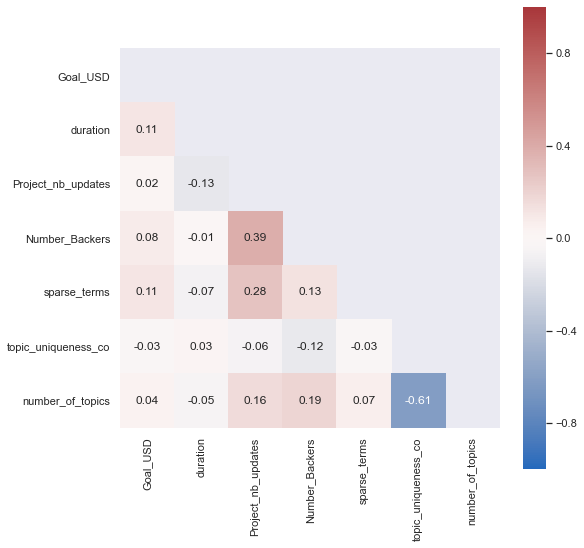

In [140]:
mask = np.zeros_like(df[predictor_set].corr())
mask[np.triu_indices_from(mask)] = True

# How to remove redundant correlation
# <https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib>
# Correlation matrix
sns.set(rc={'figure.figsize': (8.5,8.5)})
sns.heatmap(df[predictor_set].corr().round(2), vmin=-1, vmax=1, square=True, cmap='vlag', annot=True, mask=mask);


In [143]:
pd.calculate_pvalues(df[predictor_set])

AttributeError: module 'pandas' has no attribute 'calculate_pvalues'

In [145]:

from scipy.stats import pearsonr

In [152]:
def calculate_pvalues(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [pearsonr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

# code adapted from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance/49040342
def correlation_matrix(df,columns):
    rho = df[columns].corr()
    pval = calculate_pvalues(df[columns])
    # create three masks
    r0 = rho.applymap(lambda x: '{:.2f}'.format(x))
    r1 = rho.applymap(lambda x: '{:.2f}*'.format(x))
    r2 = rho.applymap(lambda x: '{:.2f}**'.format(x))
    r3 = rho.applymap(lambda x: '{:.2f}***'.format(x))
    # apply marks
    rho = rho.mask(pval>0.01,r0)
    rho = rho.mask(pval<=0.1,r1)
    rho = rho.mask(pval<=0.05,r2)
    rho = rho.mask(pval<=0.01,r3)
    return rho

columns = ['succesful'] + predictor_set
correlation_matrix(df[predictor_set+['succesful']],columns)



,succesful,Goal_USD,duration,Project_nb_updates,Number_Backers,sparse_terms,topic_uniqueness_co,number_of_topics
succesful,1.00***,-0.24***,-0.24***,0.47***,0.23***,0.13***,-0.20***,0.17***
Goal_USD,-0.24***,1.00***,0.11**,0.02,0.08,0.11**,-0.03,0.04
duration,-0.24***,0.11**,1.00***,-0.13***,-0.01,-0.07,0.03,-0.05
Project_nb_updates,0.47***,0.02,-0.13***,1.00***,0.39***,0.28***,-0.06,0.16***
Number_Backers,0.23***,0.08,-0.01,0.39***,1.00***,0.13***,-0.12**,0.19***
sparse_terms,0.13***,0.11**,-0.07,0.28***,0.13***,1.00***,-0.03,0.07
topic_uniqueness_co,-0.20***,-0.03,0.03,-0.06,-0.12**,-0.03,1.00***,-0.61***
number_of_topics,0.17***,0.04,-0.05,0.16***,0.19***,0.07,-0.61***,1.00***
